In [1]:
import jupyterthemes as jt
from jupyterthemes import jtplot
!jt -l
!jt -t onedork -ofs 10 -dfs 9 -nfs 9 -tfs 11
jtplot.style(theme = 'onedork', fscale = 1.4, context = 'notebook', ticks = True, grid = False)

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from matplotlib import pylab as plt
from num2words import num2words
import pandas as pd
import numpy as np
import seaborn as sns
import re
import pickle
import zipfile

In [3]:
#load preprocess data
data = pd.read_csv('clear_data.csv')

#target
target = data['is_bad']

#TfidfVectorizer(1-3 gramm)
vectorizer = TfidfVectorizer(ngram_range = (1, 3))

#train tfidf
train = vectorizer.fit_transform(data['clear_text'])

In [4]:
#save vectorizer.pkl
with open('vectorizer.pkl', 'wb') as vectorizer_pkl:
    pickle.dump(vectorizer, vectorizer_pkl)
    
#save vectorizer.zip
with zipfile.ZipFile('vectorizer.zip', 'w') as vectorizer_zip:
    vectorizer_zip.write('vectorizer.pkl')

In [5]:
#cross validation strategy
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

#Logistic regression
logreg = LogisticRegression(solver = 'liblinear', random_state = 42)

#Regularization
params_grid = {
               'penalty' : ['l1', 'l2']
}

#GridSearchCV
grid_cv = GridSearchCV(logreg, params_grid, cv = kf, scoring = 'roc_auc')
grid_cv.fit(train, target)
print (grid_cv.best_params_)
print ('ROC_AUC on CV:', grid_cv.best_score_)

#Tune C
params_grid = {
               'C' : [0.1, 1, 10, 25, 50]
}

#GridSearchCV
grid_cv = GridSearchCV(grid_cv.best_estimator_, params_grid, cv = kf, scoring = 'roc_auc')
grid_cv.fit(train, target)
print (grid_cv.best_params_)
print ('ROC_AUC on CV:', grid_cv.best_score_)

{'penalty': 'l2'}
ROC_AUC on CV: 0.9530181707510297
{'C': 50}
ROC_AUC on CV: 0.9651369187480008


In [6]:
logreg = grid_cv.best_estimator_

#fit model
logreg.fit(train, target)

#save logreg.pkl
with open('logreg.pkl', 'wb') as logreg_pkl:
    pickle.dump(logreg, logreg_pkl)
    
#save logreg.zip
with zipfile.ZipFile('logreg.zip', 'w') as logreg_zip:
    logreg_zip.write('logreg.pkl')

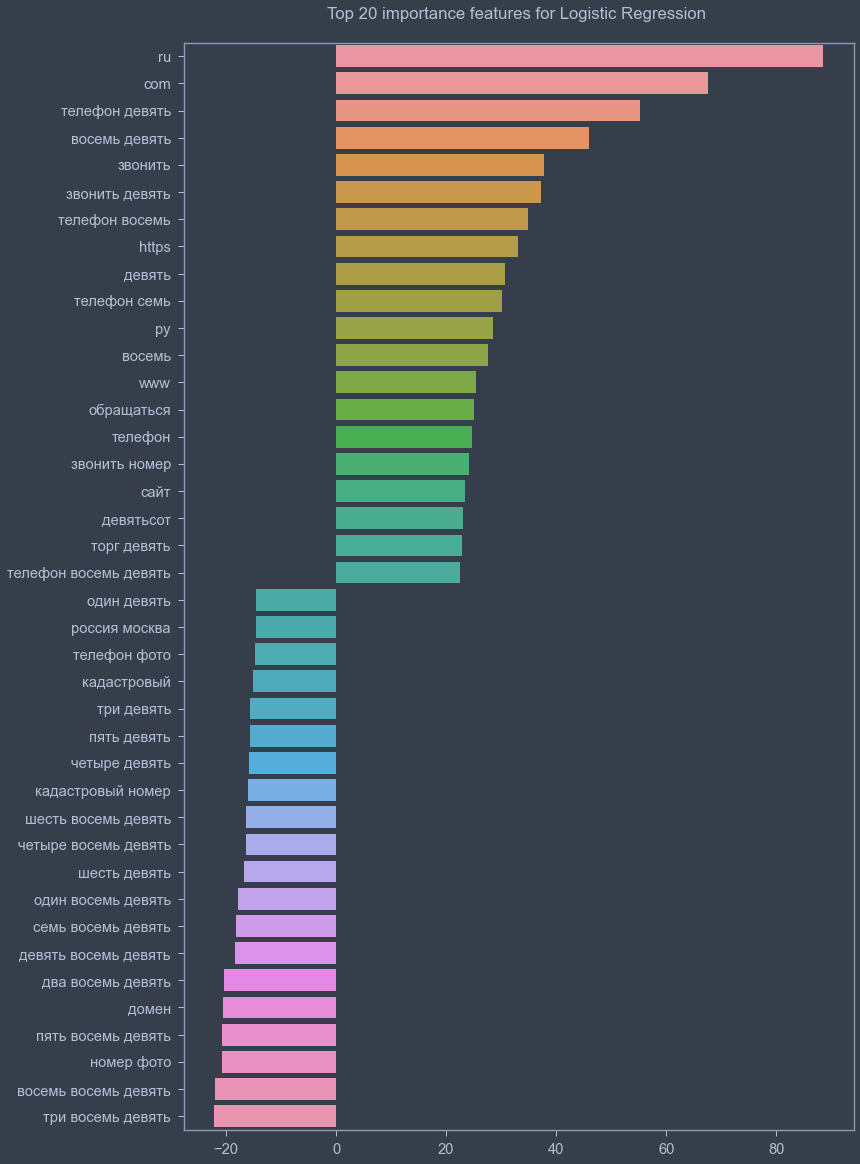

In [7]:
argmax = np.ravel(np.argsort(logreg.coef_))[-20:][: : -1]
argmin = np.ravel(np.argsort(logreg.coef_))[:20][: : -1]

top_ngrams = []
for i in (np.hstack((argmax, argmin))):
    top_ngrams.append(vectorizer.get_feature_names()[i])

plt.figure(figsize = (12, 20))
sns.barplot(np.ravel(logreg.coef_)[np.hstack((argmax, argmin))], top_ngrams)
plt.title('Top 20 importance features for Logistic Regression \n')
plt.show()